In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

PATH = r"data/processed/thickener_timeseries_deadband0p27_sp4.parquet"
df = pd.read_parquet(PATH)

print(df.shape)
print(df.columns.tolist())
df.head()

(25920, 39)
['timestamp', 'Qf_pulp_m3h', 'Qf_dilution_m3h', 'Qf_total_m3h', 'Qf_m3h', 'Solids_f_pct', 'Feedwell_Solids_pct', 'FeedDilution_On', 'FeedDilution_factor', 'PSD_fines_idx', 'Clay_pct', 'Clay_idx', 'Floc_gpt', 'UF_capacity_factor', 'Qu_base_m3h', 'Qu_sp_delta_m3h', 'Qu_m3h', 'Solids_u_pct', 'BedLevel_m', 'UF_YieldStress_Pa', 'Bogging_factor', 'RakeTorque_kNm', 'RakeTorque_pct', 'Overflow_Turb_NTU_clean', 'Overflow_Turb_NTU', 'ControlMode', 'OperatorAction', 'RecommendedAction', 'ExpectedTradeoff', 'ActionScore_turb', 'ActionScore_torque', 'WaterRecovery_proxy', 'spec_limit_NTU', 'event_limit_NTU', 'event_now', 'event_type_raw', 'event_type', 'Regime', 'target_event_30m']


,timestamp,Qf_pulp_m3h,Qf_dilution_m3h,Qf_total_m3h,Qf_m3h,Solids_f_pct,Feedwell_Solids_pct,FeedDilution_On,FeedDilution_factor,PSD_fines_idx,...,ActionScore_turb,ActionScore_torque,WaterRecovery_proxy,spec_limit_NTU,event_limit_NTU,event_now,event_type_raw,event_type,Regime,target_event_30m
0,2026-01-01 00:00:00,599.873690,0.0,599.873690,599.873690,30.662771,30.415933,0,1.0,0.137223,...,0.0,0.0,0.250852,200.0,100.0,0,NONE,NONE,NORMAL,0
1,2026-01-01 00:05:00,550.283167,0.0,550.283167,550.283167,31.125261,31.108630,0,1.0,0.127340,...,0.0,0.0,0.359864,200.0,100.0,0,NONE,NONE,NORMAL,0
2,2026-01-01 00:10:00,558.605725,0.0,558.605725,558.605725,29.347387,29.934241,0,1.0,0.123208,...,0.0,0.0,0.171562,200.0,100.0,0,NONE,NONE,NORMAL,0
3,2026-01-01 00:15:00,600.626605,0.0,600.626605,600.626605,32.246723,32.142964,0,1.0,0.119377,...,0.0,0.0,0.244958,200.0,100.0,0,NONE,NONE,NORMAL,0
4,2026-01-01 00:20:00,606.473918,0.0,606.473918,606.473918,32.598267,32.101219,0,1.0,0.113533,...,0.0,0.0,0.280690,200.0,100.0,0,NONE,NONE,NORMAL,0


In [2]:
# Tipos y nulos
na = df.isna().mean().sort_values(ascending=False)
print("Top NA rates:\n", na.head(15))

# Rangos de variables clave
cols = [
    "Overflow_Turb_NTU_clean", "Overflow_Turb_NTU",
    "event_now", "target_event_30m", "event_type",
    "Clay_idx", "PSD_fines_idx", "UF_capacity_factor",
    "Qu_m3h", "BedLevel_m", "UF_YieldStress_Pa",
    "RakeTorque_kNm", "RakeTorque_pct",
    "Floc_gpt", "ControlMode"
]
print(df[cols].describe(include="all").T)

# Chequeo de timestamp
print(df["timestamp"].min(), df["timestamp"].max())

Top NA rates:
 Qf_m3h                 0.009992
Overflow_Turb_NTU      0.009992
Solids_u_pct           0.009992
Qf_dilution_m3h        0.000000
Qf_total_m3h           0.000000
Qf_pulp_m3h            0.000000
timestamp              0.000000
Feedwell_Solids_pct    0.000000
Solids_f_pct           0.000000
PSD_fines_idx          0.000000
FeedDilution_On        0.000000
Clay_idx               0.000000
Floc_gpt               0.000000
UF_capacity_factor     0.000000
FeedDilution_factor    0.000000
dtype: float64
                           count unique   top   freq        mean        std  \
Overflow_Turb_NTU_clean  25920.0    NaN   NaN    NaN   54.494879  33.043173   
Overflow_Turb_NTU        25661.0    NaN   NaN    NaN   53.359672  32.630605   
event_now                25920.0    NaN   NaN    NaN    0.046644   0.210878   
target_event_30m         25920.0    NaN   NaN    NaN    0.046644   0.210878   
event_type                 25920      3  NONE  24711         NaN        NaN   
Clay_idx        

# Columnas de interes para el analisis y modelamiento de acuerdo con un escenario real

In [3]:
Core = [
    # Entrada
    'Qf_total_m3h',        # Caudal total de alimentación
    'Solids_f_pct',        # % sólidos en feed (deshidratador típicamente mide)
    'FeedDilution_On',     # Dilución sí/no
    
    # Proceso
    'Qu_m3h',              # Caudal underflow (medido o estimado)
    'BedLevel_m',          # Nivel del lecho (ultrasónico o similar)
    'RakeTorque_kNm',      # Torque del rastrillo (dinamómetro)
    
    # Salida
    'Overflow_Turb_NTU',   # Turbidez overflow (sonda de turbidez) - CON RUIDO
    'Solids_u_pct',        # % solidos underflow (gravedad + medidor, o inferido)
    
    # Control
    'Qu_sp_delta_m3h',     # Acción sobre underflow
    'Qf_dilution_m3h',     # Caudal de dilución (si está disponible)
]


## Distribución de turbidez y prevalencias (objetivo early warning)


#### Histogramas clean vs medida

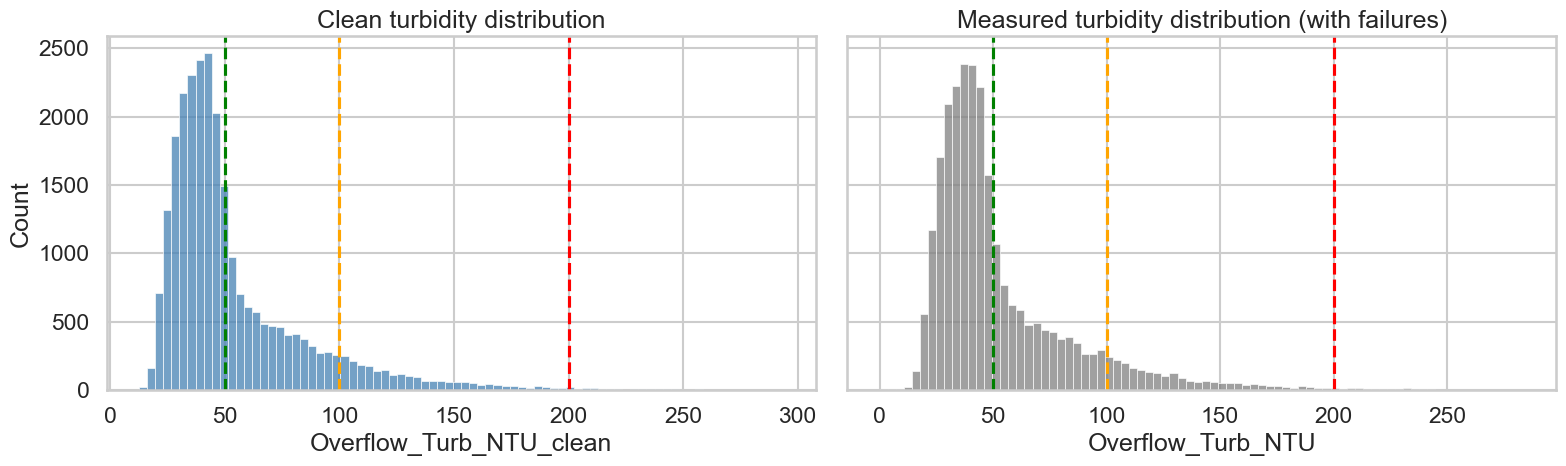

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.histplot(df, x="Overflow_Turb_NTU_clean", bins=80, ax=ax[0], color="steelblue")
ax[0].axvline(50, color="green", ls="--"); ax[0].axvline(100, color="orange", ls="--"); ax[0].axvline(200, color="red", ls="--")
ax[0].set_title("Clean turbidity distribution")

sns.histplot(df, x="Overflow_Turb_NTU", bins=80, ax=ax[1], color="gray")
ax[1].axvline(50, color="green", ls="--"); ax[1].axvline(100, color="orange", ls="--"); ax[1].axvline(200, color="red", ls="--")
ax[1].set_title("Measured turbidity distribution (with failures)")

plt.tight_layout()
plt.show()

#### Prevalencias (event_now y target_event_30m)

In [5]:
rates = {
    "event_now_rate": df["event_now"].mean(),
    "target_event_30m_rate": df["target_event_30m"].mean(),
    "manual_rate": (df["ControlMode"] == "MANUAL").mean(),
}
rates

{'event_now_rate': np.float64(0.04664351851851852),
 'target_event_30m_rate': np.float64(0.04664351851851852),
 'manual_rate': np.float64(0.23935185185185184)}

#### Series representativas

Event days: DatetimeIndex(['2026-01-15', '2026-01-16', '2026-01-17', '2026-01-18',
               '2026-01-19', '2026-01-20', '2026-01-21', '2026-01-22',
               '2026-01-23', '2026-01-24'],
              dtype='datetime64[us]', name='timestamp', freq=None)


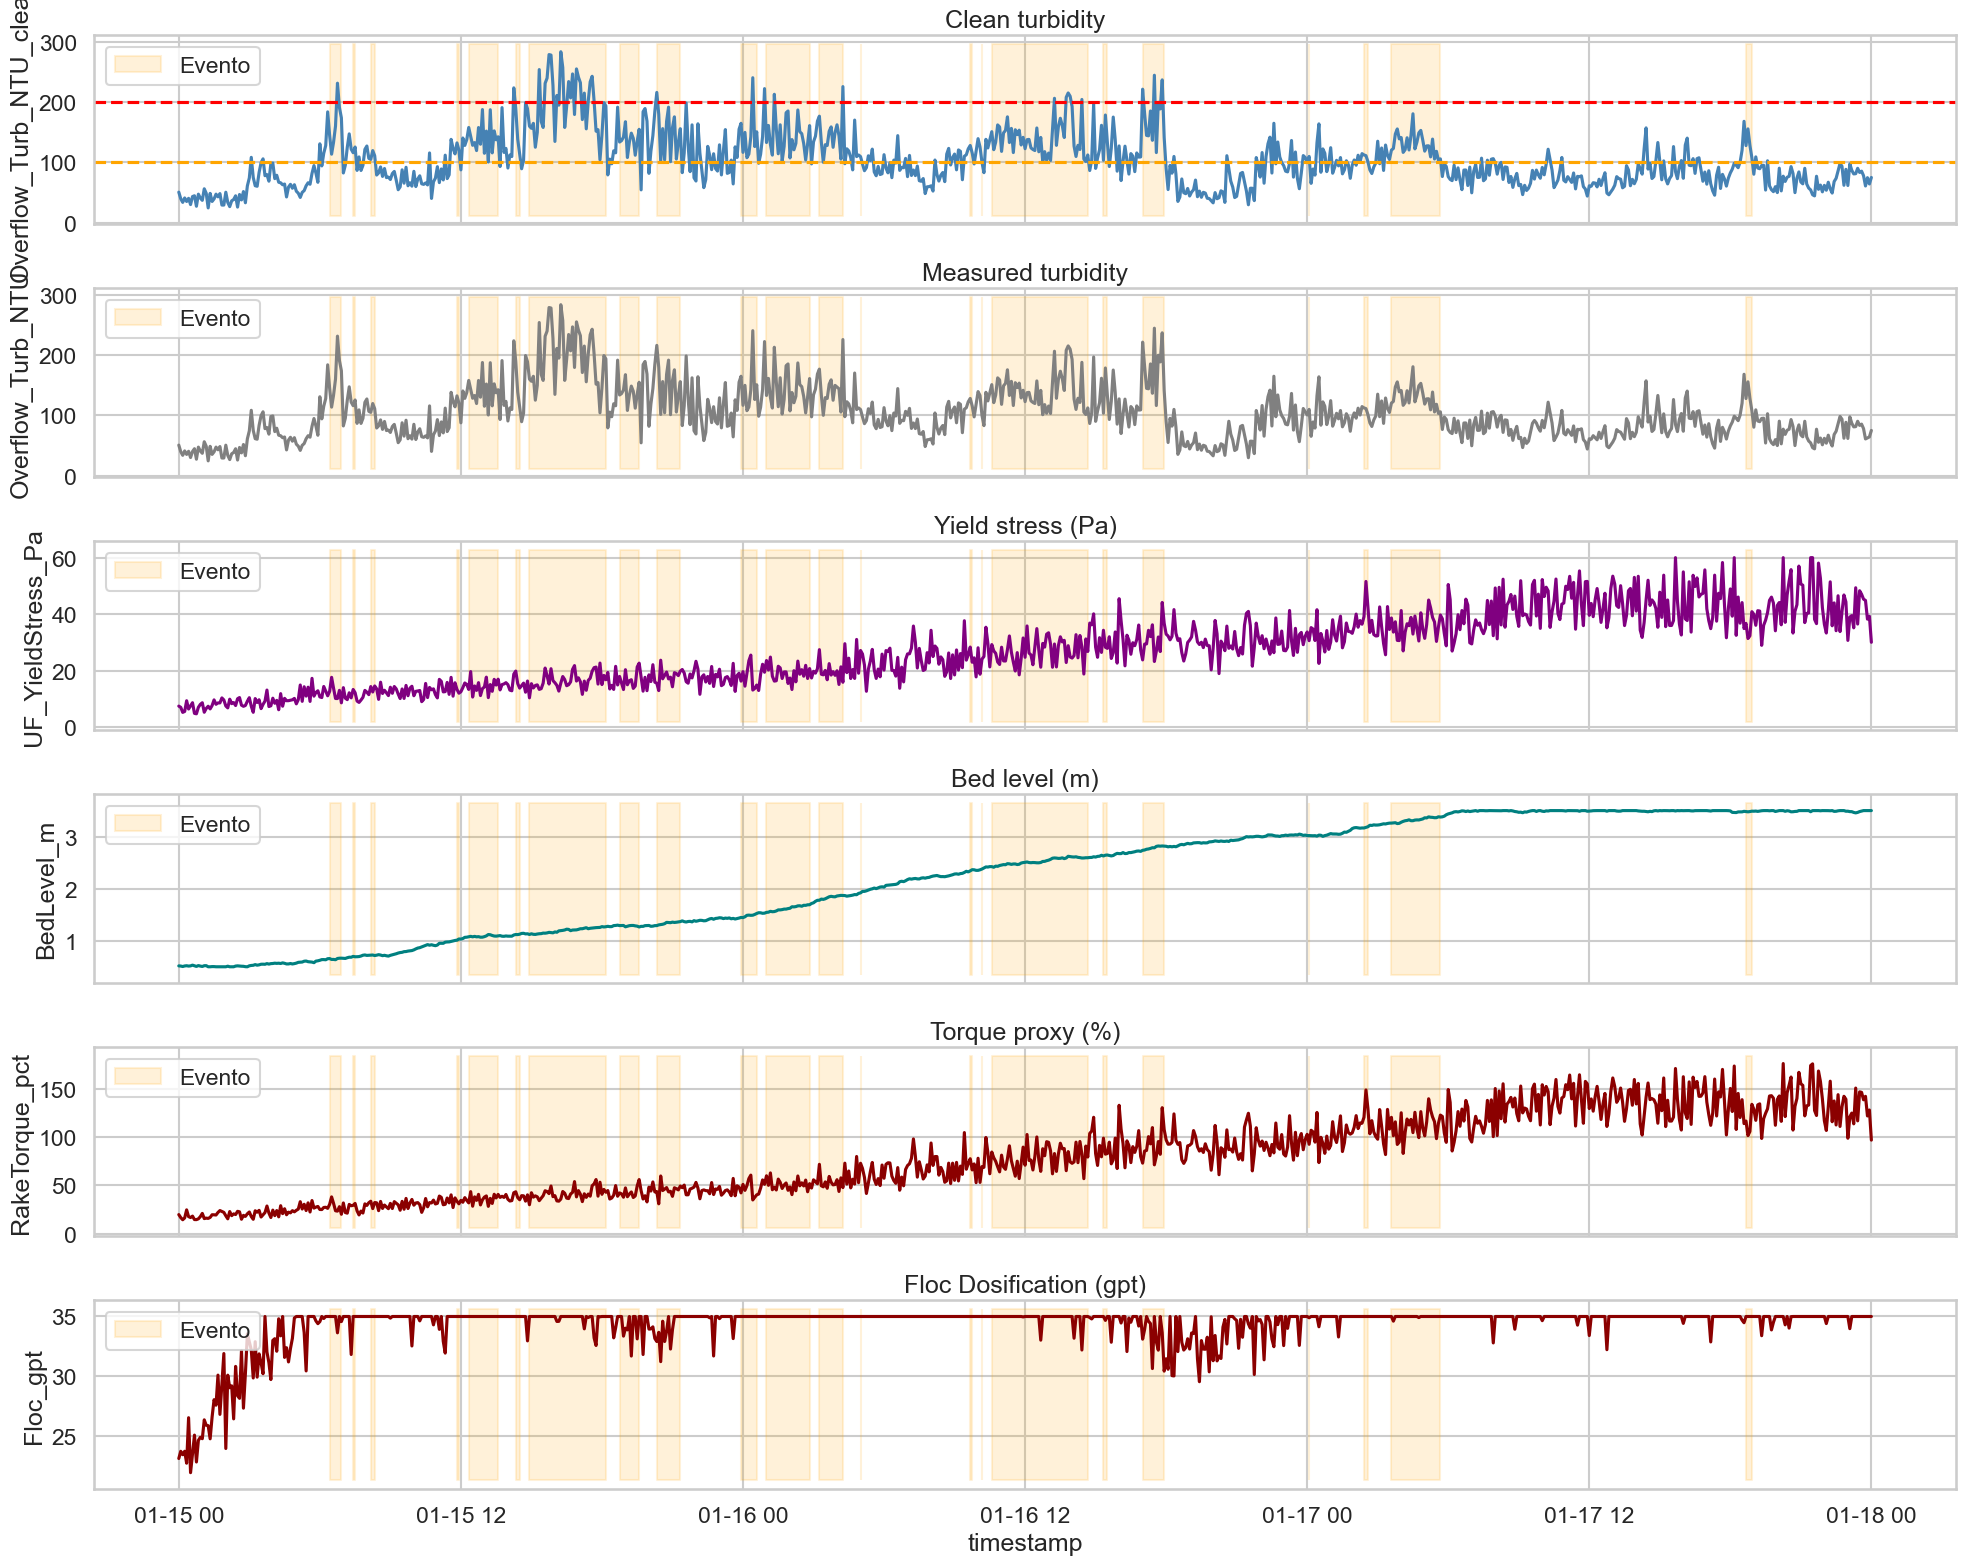

In [6]:
# elige ventana donde haya eventos
df2 = df.set_index("timestamp").sort_index()

# ejemplo: busca un día con eventos
days_with_events = df2.resample("D")["event_now"].max()
event_days = days_with_events[days_with_events > 0].index
print("Event days:", event_days[:10])

start = event_days[0]
end = start + pd.Timedelta(days=3)
w = df2.loc[start:end].copy()

fig, ax = plt.subplots(6, 1, figsize=(20, 16), sharex=True)

sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU_clean", ax=ax[0], color="steelblue")
ax[0].axhline(100, color="orange", ls="--"); ax[0].axhline(200, color="red", ls="--")
ax[0].set_title("Clean turbidity")

sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU", ax=ax[1], color="gray")
ax[1].set_title("Measured turbidity")

sns.lineplot(w, x=w.index, y="UF_YieldStress_Pa", ax=ax[2], color="purple")
ax[2].set_title("Yield stress (Pa)")  

sns.lineplot(w, x=w.index, y="BedLevel_m", ax=ax[3], color="teal")
ax[3].set_title("Bed level (m)")

sns.lineplot(w, x=w.index, y="RakeTorque_pct", ax=ax[4], color="darkred")
ax[4].set_title("Torque proxy (%)")

sns.lineplot(w, x=w.index, y="Floc_gpt", ax=ax[5], color="darkred")
ax[5].set_title("Floc Dosification (gpt)")


for a in ax.flat:
        ev = w["event_now"].astype(bool).values
        # Dibujamos el fondo naranja en las zonas de evento
        a.fill_between(w.index, 
                       a.get_ylim()[0], 
                       a.get_ylim()[1], 
                       where=ev, 
                       color="orange", 
                       alpha=0.15, # Un poco más visible
                       step="pre",
                       label="Evento")
        a.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Diagnosis: CLAY vs UF (solo durante evento)

#### Conteo de event_type

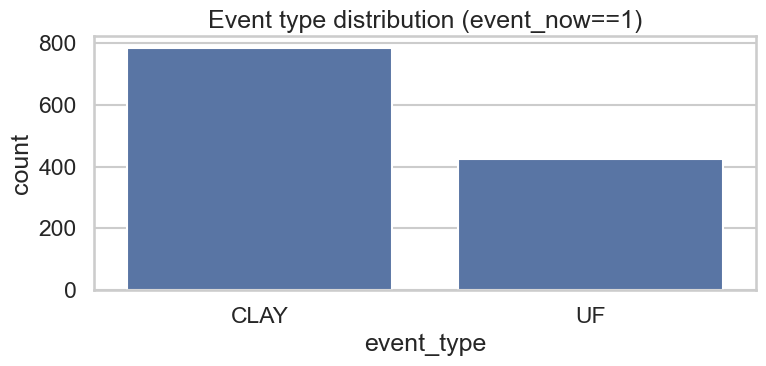

In [7]:
ev = df[df["event_now"] == 1].copy()

plt.figure(figsize=(8,4))
sns.countplot(ev, x="event_type", order=ev["event_type"].value_counts().index)
plt.title("Event type distribution (event_now==1)")
plt.tight_layout()
plt.show()

#### Pairplots/relaciones clave (firma)

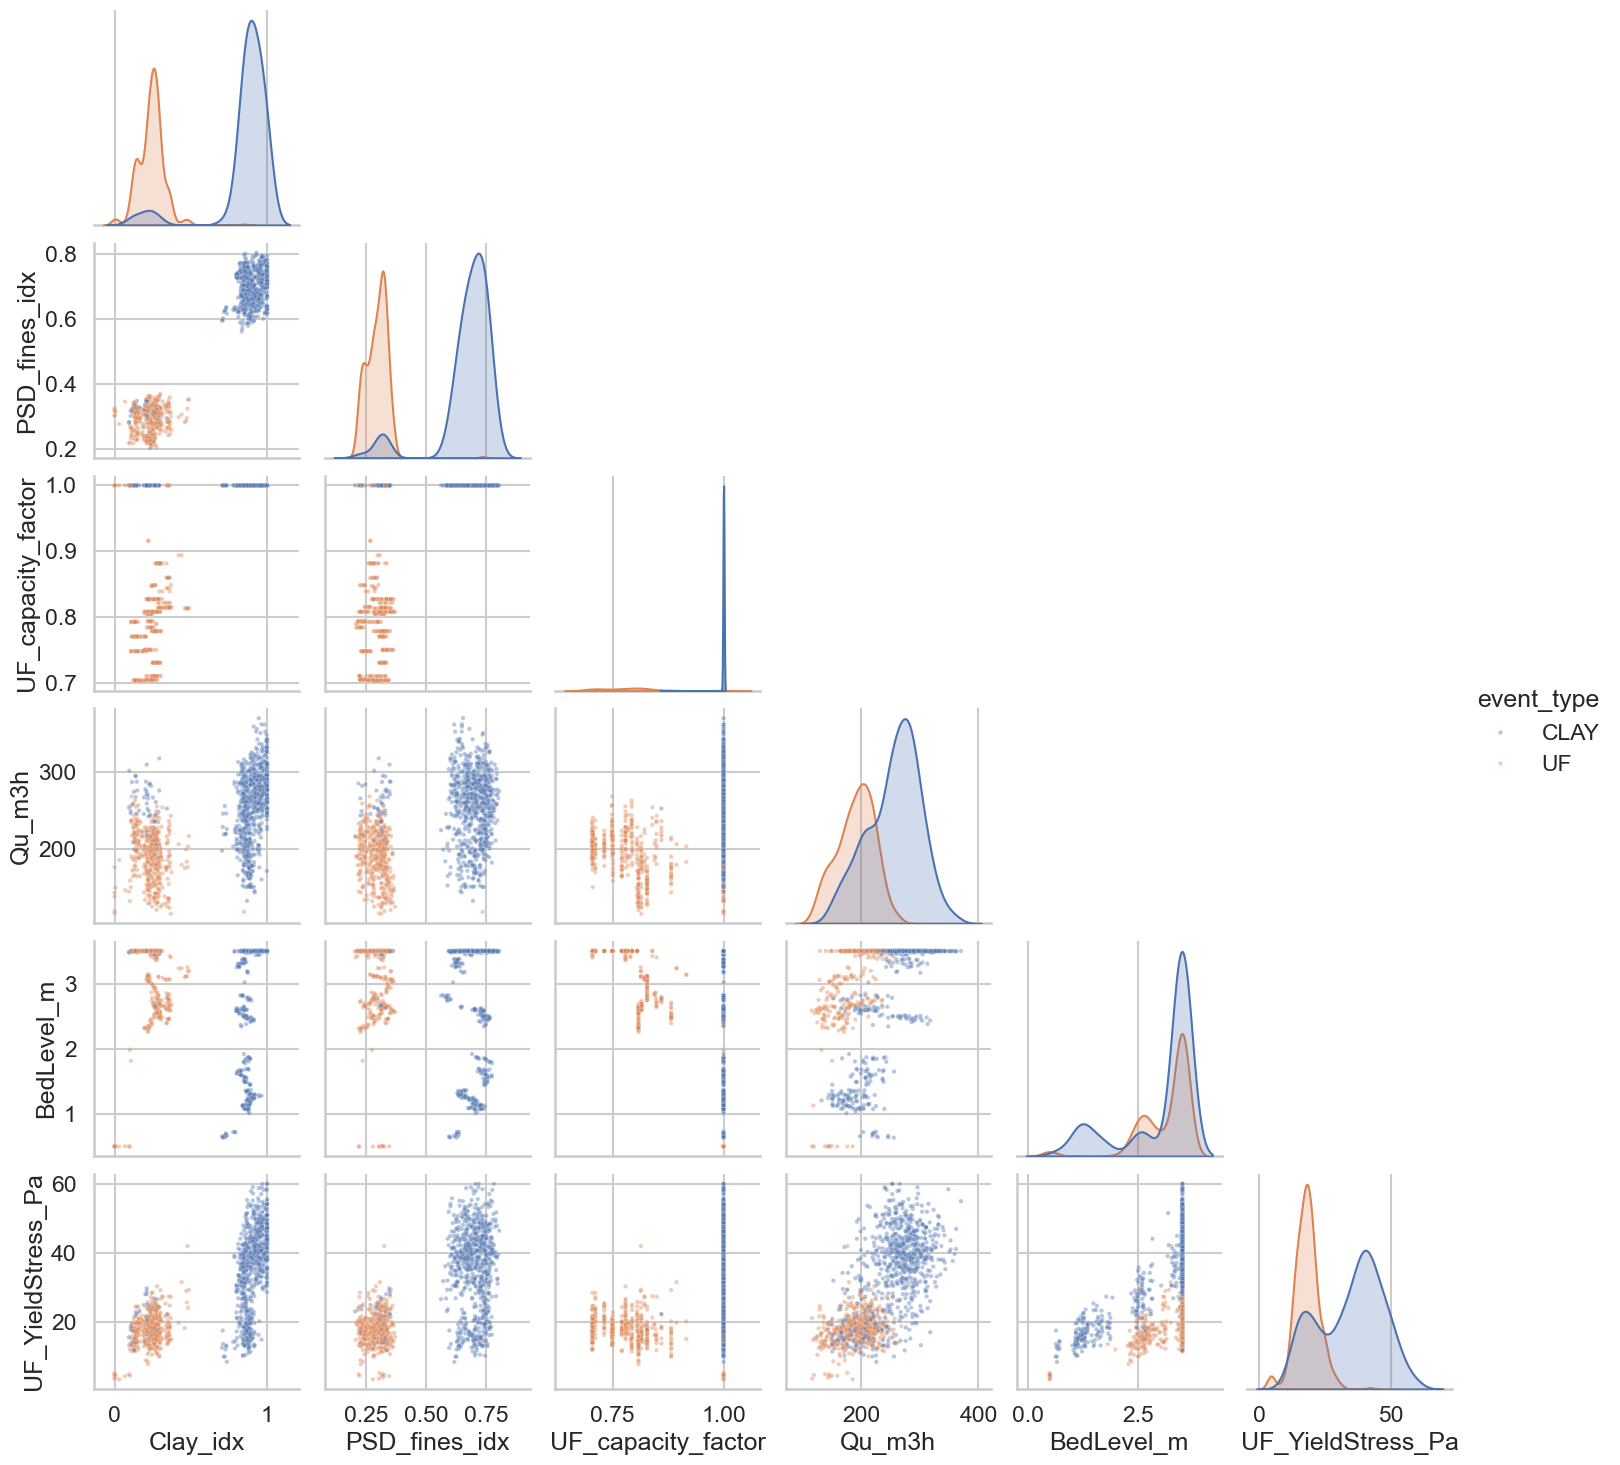

In [8]:
ev = df[df["event_now"] == 1].copy()
evs = ev.sample(min(2500, len(ev)), random_state=42)

vars_ = ["Clay_idx", "PSD_fines_idx", "UF_capacity_factor", "Qu_m3h", "BedLevel_m", "UF_YieldStress_Pa"]
sns.pairplot(evs, vars=vars_, hue="event_type", corner=True, plot_kws=dict(s=10, alpha=0.4))
plt.show()

Clay/fines: en la distribución de finos y presencia de arcilla se puede ver que un Clay_idx > 0.8 y una proporción de finos (PSD_fines_idx) mayor a 0.6 identifica claramente un evento CLAY. El evento UF, en cambio, se caracteriza por valores bajos de arcilla y finos (< 0.5) pero con una caída significativa en UF_capacity_factor — esa es su firma maestra.

#### Boxplots por tipo de evento (intensidad)

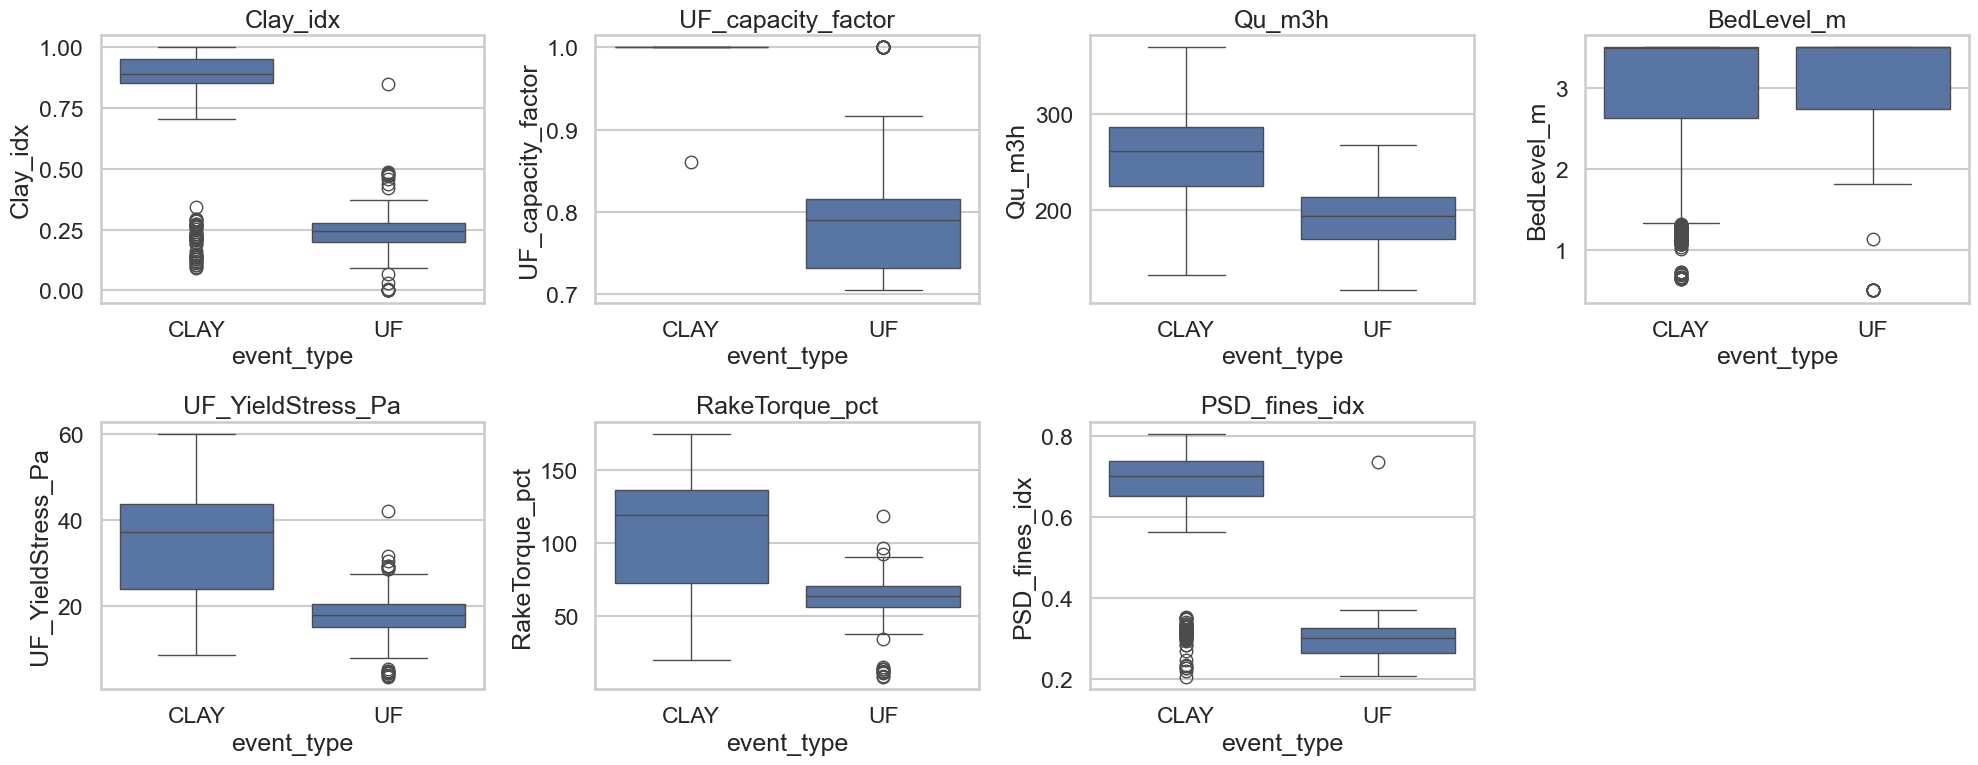

In [9]:
ev = df[df["event_now"] == 1].copy()

features = ["Clay_idx", "UF_capacity_factor", "Qu_m3h", "BedLevel_m", "UF_YieldStress_Pa", "RakeTorque_pct", "PSD_fines_idx"]
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for ax, f in zip(axes, features):
    sns.boxplot(ev, x="event_type", y=f, ax=ax)
    ax.set_title(f)

# Hide unused subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

1. **CLAY: El evento de alta variabilidad y extremos**
Firma de "Ruido": En Clay_idx, BedLevel_m y PSD_fines_idx, el evento CLAY tiene una distribución amplia con muchos puntos extremos. Aunque su firma es de valores altos, es un evento inestable y variable.
Esfuerzo y Torque: Es el que presenta mayor rango en UF_YieldStress_Pa y RakeTorque_pct. La firma de CLAY es "pesada": exige mucho torque al rake, de forma muy variable (caja alta).

2. **UF: El evento de "Baja Intensidad"**
Firma de Oposición: Es casi el opuesto al CLAY. En variables como Clay_idx, PSD_fines_idx y UF_YieldStress_Pa, sus cajas están situadas más abajo.
Diferenciador Clave: En UF_capacity_factor, es el único evento donde la capacidad cae drásticamente. Esta es la **firma maestra del UF**: una caída en el factor de capacidad que el evento CLAY no tiene.

**Conclusión para el análisis:**
- Para identificar CLAY: busca valores altos en Clay_idx con alta variabilidad, alto torque y PSD_fines_idx elevado.
- Para identificar UF: busca la caída en UF_capacity_factor y valores bajos de finos y arcillas.

## Early warning: señales 30 minutos antes (comparación target_event_30m)

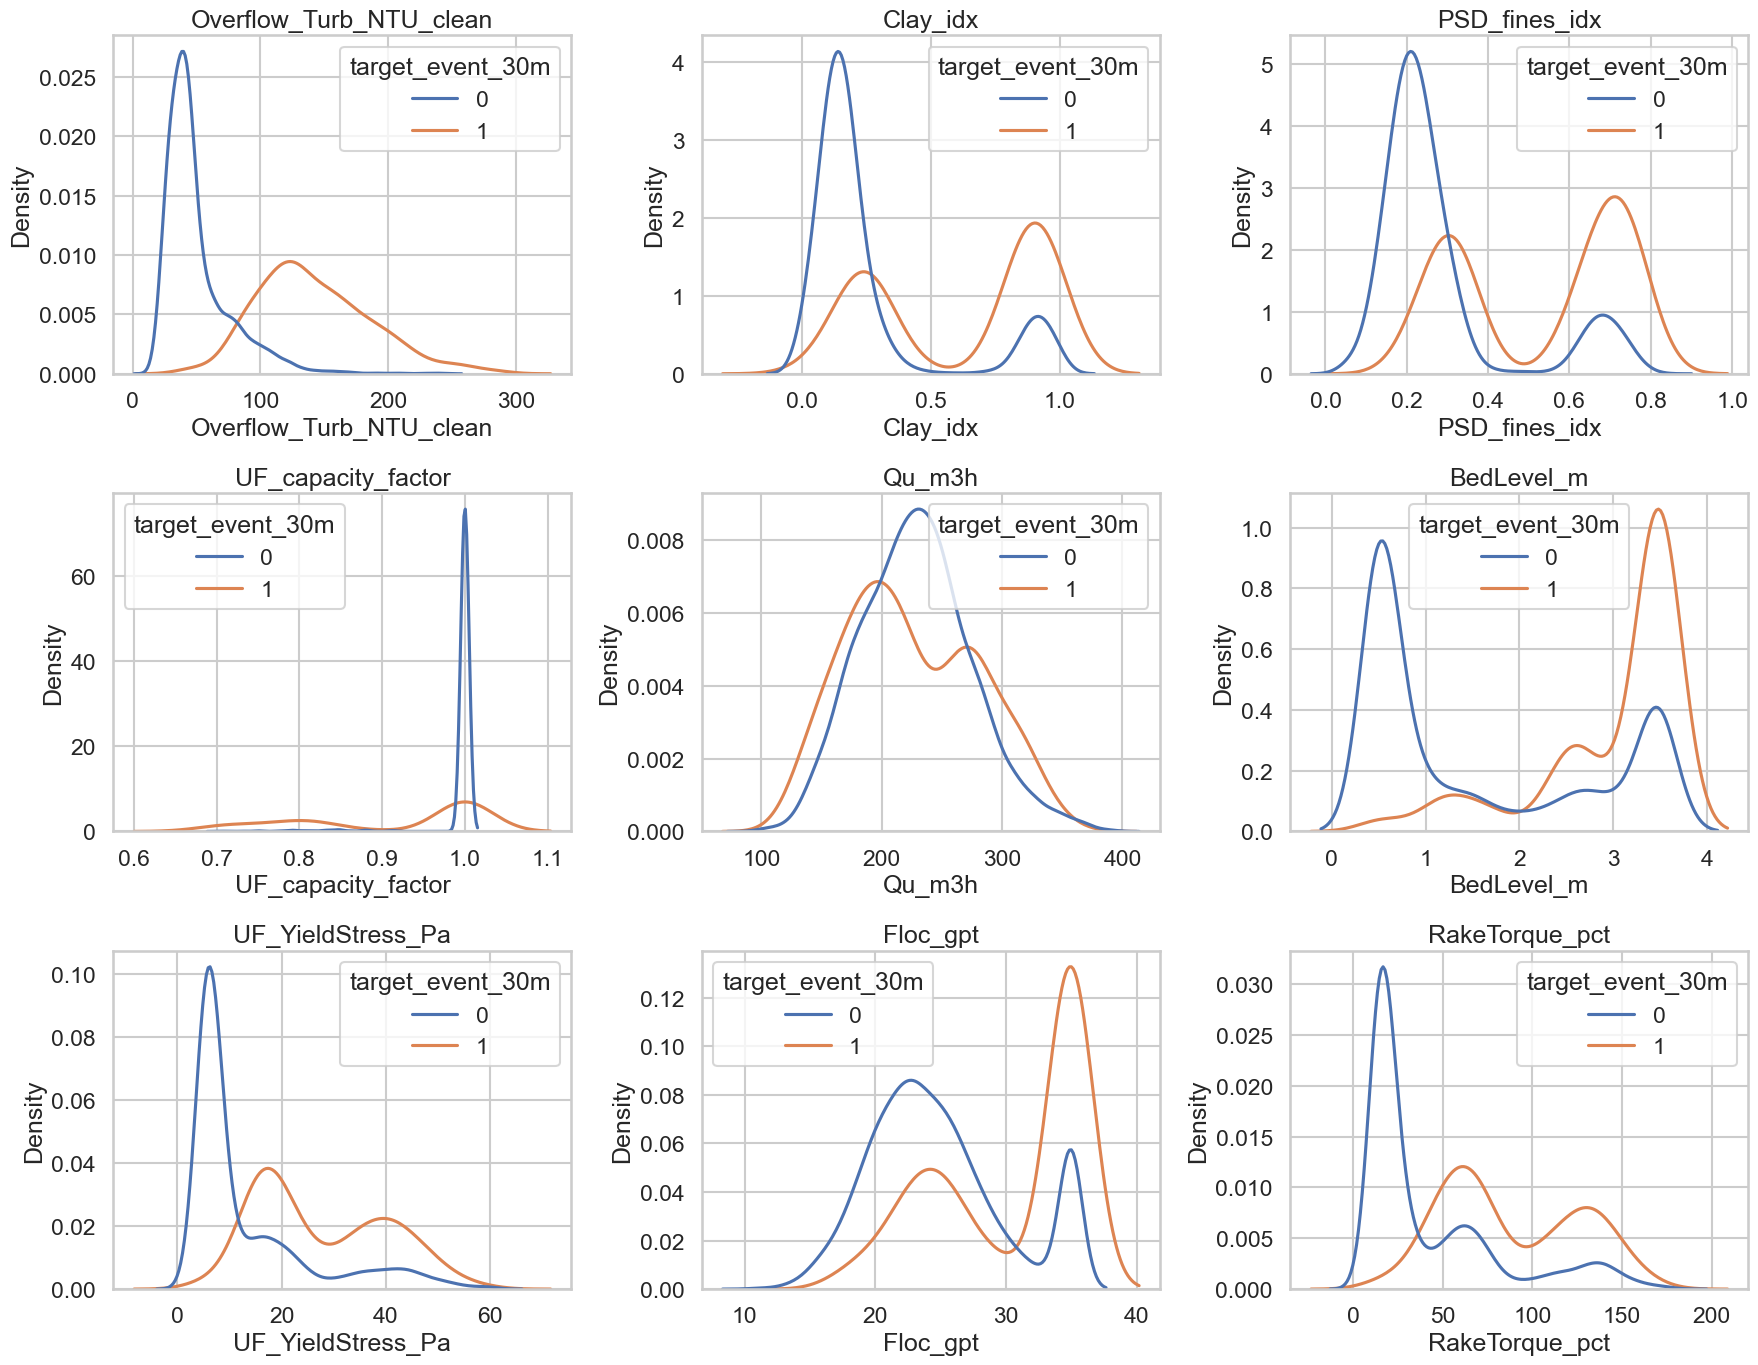

In [10]:
cols = ["Overflow_Turb_NTU_clean", "Clay_idx", "PSD_fines_idx", "UF_capacity_factor", "Qu_m3h", "BedLevel_m",
        "UF_YieldStress_Pa", "Floc_gpt", "RakeTorque_pct"]

sample = df.sample(8000, random_state=1).copy()
sample["target_event_30m"] = sample["target_event_30m"].astype(int)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for ax, c in zip(axes, cols):
    sns.kdeplot(sample, x=c, hue="target_event_30m", common_norm=False, ax=ax)
    ax.set_title(c)

plt.tight_layout()
plt.show()

#### Feature importance quick proxy (delta_over_IQR)

In [11]:
features = [
    "Overflow_Turb_NTU_clean",
    "Clay_idx", "PSD_fines_idx",
    "UF_capacity_factor", "Qu_m3h",
    "BedLevel_m", "UF_YieldStress_Pa",
    "Floc_gpt",
    "RakeTorque_pct",
]

tmp = df.dropna(subset=["target_event_30m"]).copy()
g0 = tmp[tmp["target_event_30m"] == 0]
g1 = tmp[tmp["target_event_30m"] == 1]

rows = []
for f in features:
    m0 = float(g0[f].median())
    m1 = float(g1[f].median())
    iqr = float(tmp[f].quantile(0.75) - tmp[f].quantile(0.25)) + 1e-9
    rows.append(
        {
            "feature": f,
            "median_target0": m0,
            "median_target1": m1,
            "delta": m1 - m0,
            "IQR_all": iqr,
            "delta_over_IQR": (m1 - m0) / iqr,
        }
    )

eff = pd.DataFrame(rows).sort_values("delta_over_IQR", ascending=False)
eff.reset_index(drop=True, inplace=True)

# Top 10 features by separation
eff.head(10)

,feature,median_target0,median_target1,delta,IQR_all,delta_over_IQR
0,Clay_idx,0.159039,0.849694,0.690656,1.431945e-01,4.823201
1,PSD_fines_idx,0.225424,0.650741,0.425316,1.152620e-01,3.689997
2,Overflow_Turb_NTU_clean,42.652498,134.840122,92.187623,2.914541e+01,3.163024
3,Floc_gpt,24.035448,35.000000,10.964552,7.011279e+00,1.563845
4,UF_YieldStress_Pa,7.250552,24.685014,17.434463,1.227123e+01,1.420759
5,RakeTorque_pct,20.453255,77.721665,57.268410,4.677076e+01,1.224449
6,BedLevel_m,0.793296,3.499829,2.706533,2.544360e+00,1.063738
7,UF_capacity_factor,1.000000,1.000000,0.000000,1.000000e-09,0.000000
8,Qu_m3h,227.287153,223.186710,-4.100443,6.291385e+01,-0.065176


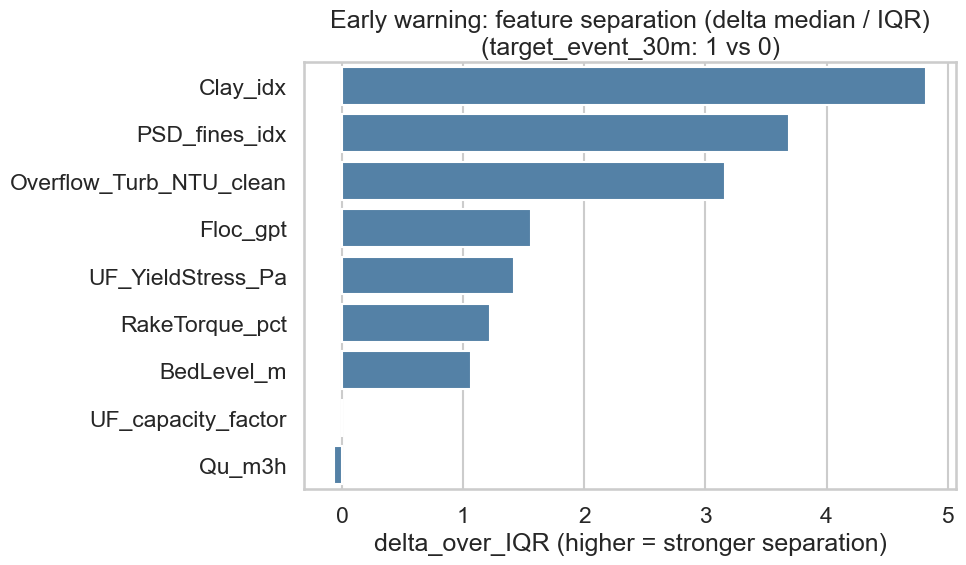

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

top = eff.head(10).copy()

plt.figure(figsize=(10,6))
sns.barplot(top, y="feature", x="delta_over_IQR", color="steelblue")
plt.title("Early warning: feature separation (delta median / IQR)\n(target_event_30m: 1 vs 0)")
plt.xlabel("delta_over_IQR (higher = stronger separation)")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Sensor health: diferencias clean vs medida y detección visual de fallas

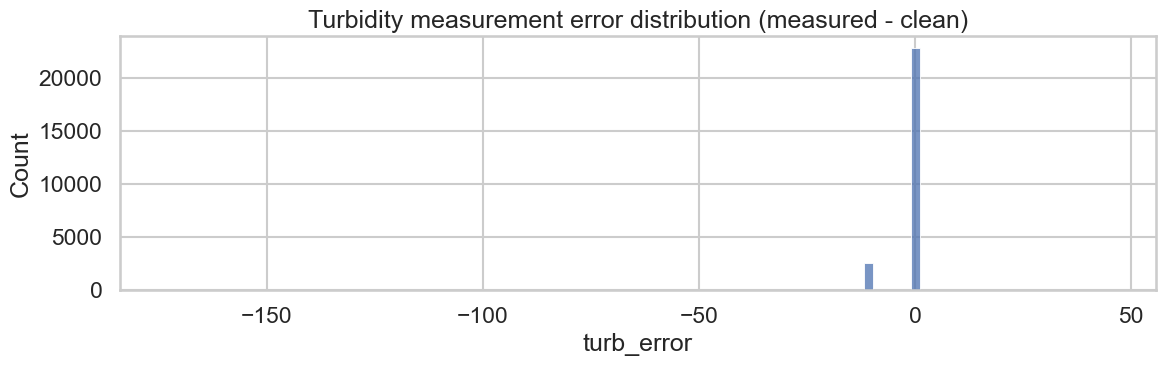

count    25661.000000
mean        -1.145374
std          5.675835
min       -173.096246
1%         -10.000000
5%         -10.000000
95%          0.000000
99%          0.000000
max         44.869041
Name: turb_error, dtype: float64


In [13]:
df_err = df.copy()
df_err["turb_error"] = df_err["Overflow_Turb_NTU"] - df_err["Overflow_Turb_NTU_clean"]

plt.figure(figsize=(12,4))
sns.histplot(df_err, x="turb_error", bins=100)
plt.title("Turbidity measurement error distribution (measured - clean)")
plt.tight_layout()
plt.show()

# puntos extremos
print(df_err["turb_error"].describe(percentiles=[0.01,0.05,0.95,0.99]))

#### Ventana con “stuck” / spikes (busca segmentos con baja variación)

timestamp
2026-01-29 18:15:00    0.0
2026-01-29 18:20:00    0.0
2026-01-29 18:25:00    0.0
2026-01-29 18:30:00    0.0
2026-01-29 18:35:00    0.0
2026-01-29 18:40:00    0.0
2026-01-29 18:45:00    0.0
2026-01-29 18:50:00    0.0
2026-01-29 18:55:00    0.0
2026-01-29 19:00:00    0.0
Name: Overflow_Turb_NTU, dtype: float64


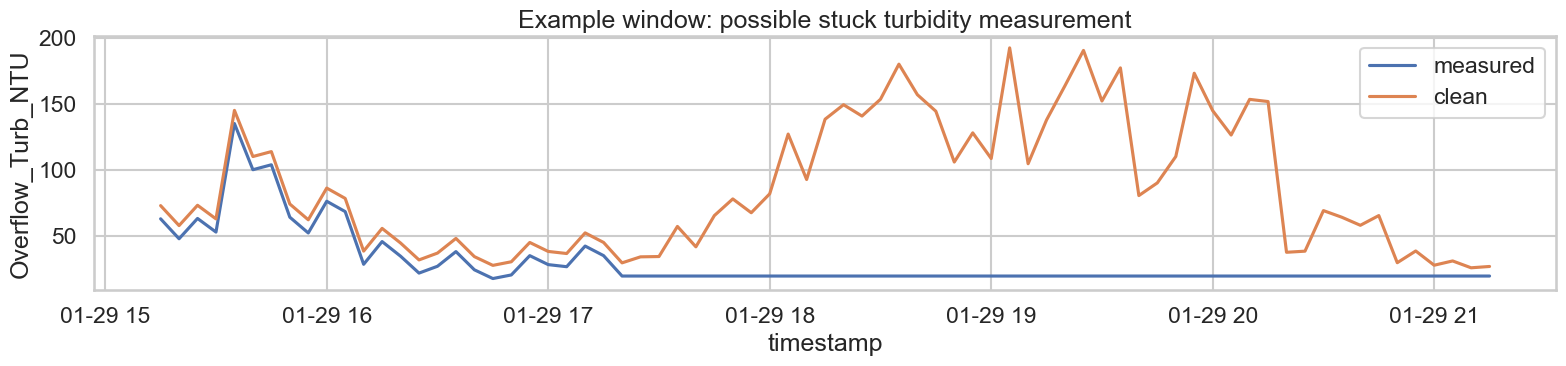

In [14]:
dft = df.set_index("timestamp").sort_index()

# rolling std bajo = potencial "stuck"
roll_std = dft["Overflow_Turb_NTU"].rolling("60min").std()
suspect = roll_std.nsmallest(10)
print(suspect)

# plotea alrededor del peor caso
t0 = suspect.index[0] - pd.Timedelta(hours=3)
t1 = suspect.index[0] + pd.Timedelta(hours=3)
w = dft.loc[t0:t1]

plt.figure(figsize=(16,4))
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU", label="measured")
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU_clean", label="clean")
plt.title("Example window: possible stuck turbidity measurement")
plt.tight_layout()
plt.show()

#### Posible sensor failures

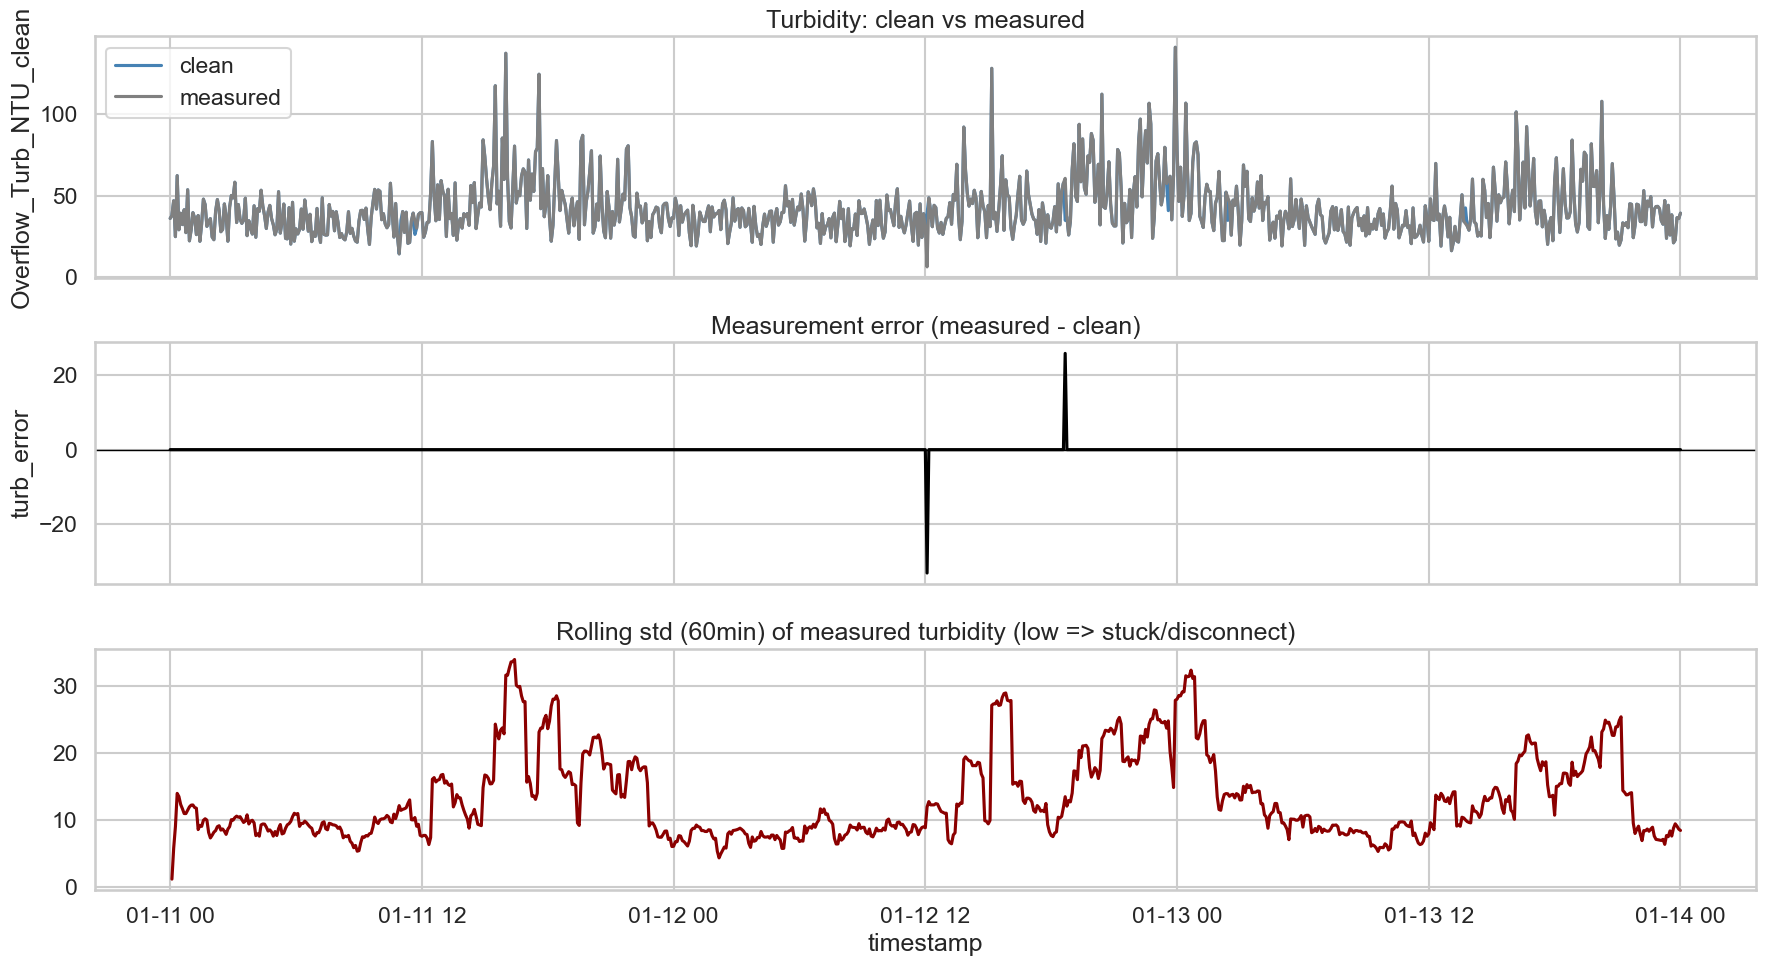

In [15]:
dft = df.set_index("timestamp").sort_index().copy()
dft["turb_error"] = dft["Overflow_Turb_NTU"] - dft["Overflow_Turb_NTU_clean"]

# Ventana: usa la misma que ya ploteaste o elige una con fallas
start = dft.index.min() + pd.Timedelta(days=10)
end = start + pd.Timedelta(days=3)
w = dft.loc[start:end].copy()

fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU_clean", ax=ax[0], label="clean", color="steelblue")
sns.lineplot(w, x=w.index, y="Overflow_Turb_NTU", ax=ax[0], label="measured", color="gray")
ax[0].set_title("Turbidity: clean vs measured")

sns.lineplot(w, x=w.index, y="turb_error", ax=ax[1], color="black")
ax[1].axhline(0, color="black", lw=1)
ax[1].set_title("Measurement error (measured - clean)")

# Stuck proxy: rolling std muy bajo
roll_std = w["Overflow_Turb_NTU"].rolling("60min").std()
sns.lineplot(x=roll_std.index, y=roll_std.values, ax=ax[2], color="darkred")
ax[2].set_title("Rolling std (60min) of measured turbidity (low => stuck/disconnect)")

plt.tight_layout()
plt.show()

## Playbook: operador vs recomendación, y trade-offs

#### Conteos de acciones

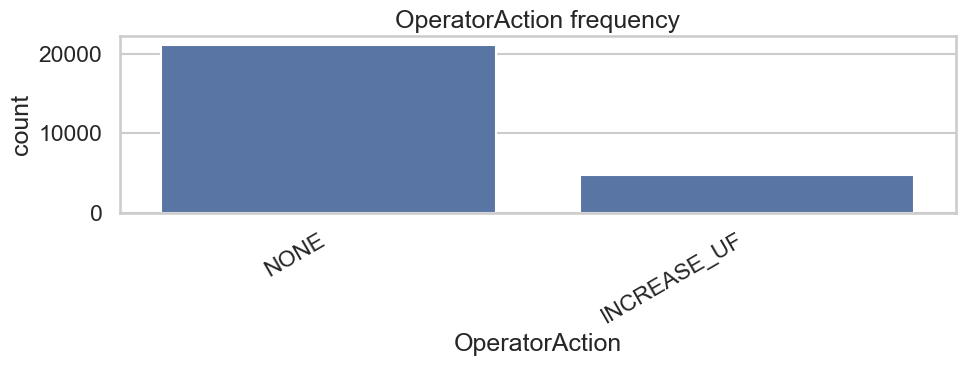

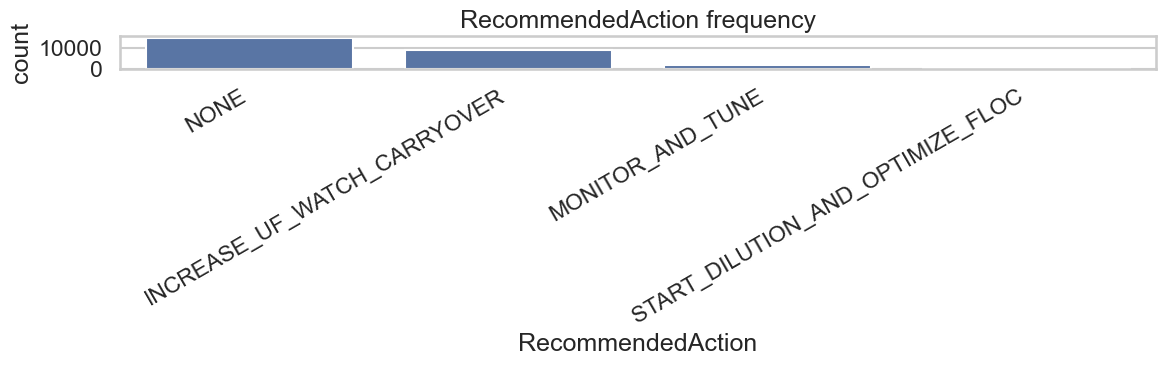

In [16]:
plt.figure(figsize=(10,4))
sns.countplot(df, x="OperatorAction", order=df["OperatorAction"].value_counts().index)
plt.title("OperatorAction frequency")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
sns.countplot(df, x="RecommendedAction", order=df["RecommendedAction"].value_counts().index)
plt.title("RecommendedAction frequency")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

#### ¿El operador hace lo recomendado?

Match rate: 0.5680941358024691
Match rate when rec != NONE: 0.0


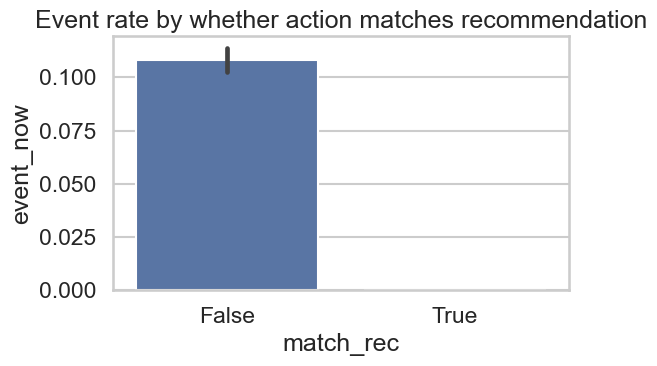

In [17]:
tmp = df.copy()
tmp["match_rec"] = (tmp["OperatorAction"].fillna("NONE") == tmp["RecommendedAction"].fillna("NONE"))

print("Match rate:", tmp["match_rec"].mean())

# Solo cuando hay recomendación (distinto de NONE)
mask = tmp["RecommendedAction"] != "NONE"
print("Match rate when rec != NONE:", tmp.loc[mask, "match_rec"].mean())

plt.figure(figsize=(6,4))
sns.barplot(tmp, x="match_rec", y="event_now", estimator=np.mean)
plt.title("Event rate by whether action matches recommendation")
plt.tight_layout()
plt.show()

#### Trade-off: efecto de subir UF (carryover)

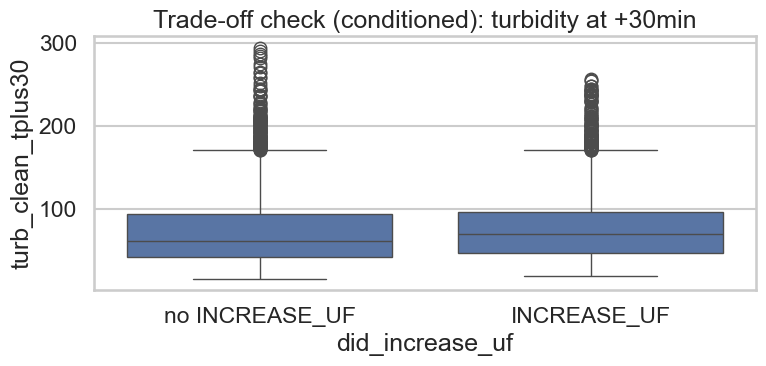

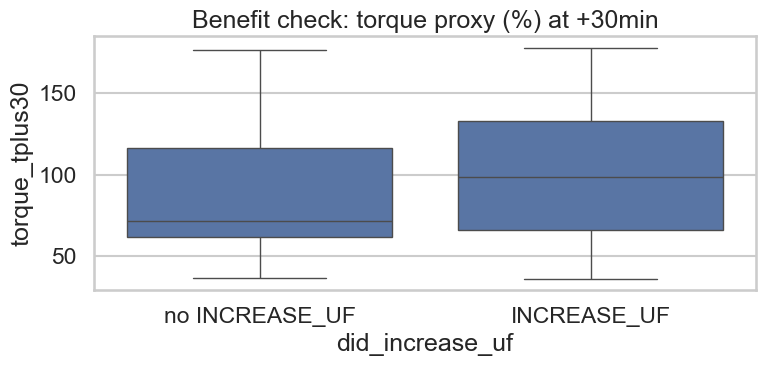

In [18]:
tmp = df.sort_values("timestamp").copy()
tmp["turb_clean_tplus30"] = tmp["Overflow_Turb_NTU_clean"].shift(-6)

# Condición de estrés mecánico similar
stress = (tmp["BedLevel_m"] > 2.6) | (tmp["RakeTorque_pct"] > 90)
sub = tmp[stress].dropna(subset=["turb_clean_tplus30"]).copy()

sub["did_increase_uf"] = (sub["OperatorAction"] == "INCREASE_UF").astype(int)

plt.figure(figsize=(8,4))
sns.boxplot(sub, x="did_increase_uf", y="turb_clean_tplus30")
plt.xticks([0,1], ["no INCREASE_UF", "INCREASE_UF"])
plt.title("Trade-off check (conditioned): turbidity at +30min")
plt.tight_layout()
plt.show()

# Complemento: efecto en torque proxy (debería mejorar)
sub["torque_tplus30"] = sub["RakeTorque_pct"].shift(-6)
plt.figure(figsize=(8,4))
sns.boxplot(sub.dropna(subset=["torque_tplus30"]), x="did_increase_uf", y="torque_tplus30")
plt.xticks([0,1], ["no INCREASE_UF", "INCREASE_UF"])
plt.title("Benefit check: torque proxy (%) at +30min")
plt.tight_layout()
plt.show()

#### Bed +30min

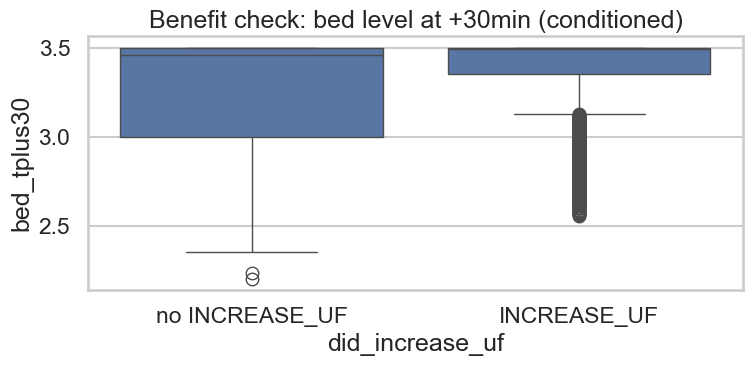

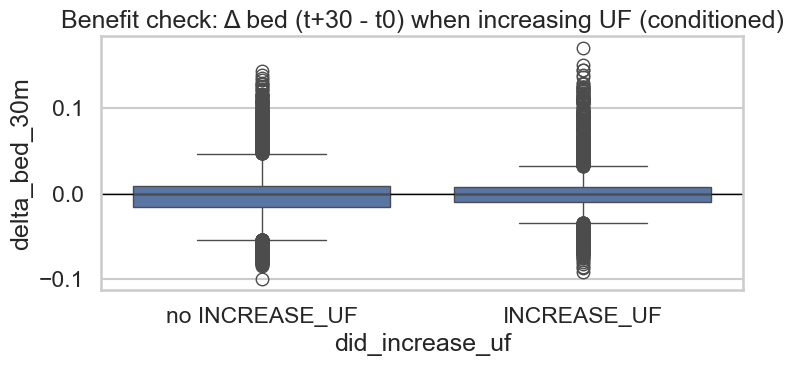

,delta_bed_30m,delta_turb_clean_30m,delta_torque_30m
no INCREASE_UF,0.0,-0.072010,-0.394537
INCREASE_UF,0.0,-0.119493,0.012179


In [19]:
tmp = df.sort_values("timestamp").copy()

# +30 min (6 steps at 5 min)
tmp["bed_tplus30"] = tmp["BedLevel_m"].shift(-6)
tmp["turb_clean_tplus30"] = tmp["Overflow_Turb_NTU_clean"].shift(-6)
tmp["torque_tplus30"] = tmp["RakeTorque_pct"].shift(-6)

# Condition on comparable "stress" states (adjust thresholds if needed)
stress = (tmp["BedLevel_m"] > 2.6) | (tmp["RakeTorque_pct"] > 90)
sub = tmp[stress].dropna(subset=["bed_tplus30", "turb_clean_tplus30", "torque_tplus30"]).copy()

sub["did_increase_uf"] = (sub["OperatorAction"] == "INCREASE_UF").astype(int)

# 1) Benefit: bed at +30 min
plt.figure(figsize=(8, 4))
sns.boxplot(sub, x="did_increase_uf", y="bed_tplus30")
plt.xticks([0, 1], ["no INCREASE_UF", "INCREASE_UF"])
plt.title("Benefit check: bed level at +30min (conditioned)")
plt.tight_layout()
plt.show()

# 2) Delta bed (t+30 - t0) is often more interpretable
sub["delta_bed_30m"] = sub["bed_tplus30"] - sub["BedLevel_m"]

plt.figure(figsize=(8, 4))
sns.boxplot(sub, x="did_increase_uf", y="delta_bed_30m")
plt.xticks([0, 1], ["no INCREASE_UF", "INCREASE_UF"])
plt.axhline(0, color="black", lw=1)
plt.title("Benefit check: Δ bed (t+30 - t0) when increasing UF (conditioned)")
plt.tight_layout()
plt.show()

# Optional: show turbidity and torque deltas too (compact summary)
sub["delta_turb_clean_30m"] = sub["turb_clean_tplus30"] - sub["Overflow_Turb_NTU_clean"]
sub["delta_torque_30m"] = sub["torque_tplus30"] - sub["RakeTorque_pct"]

summary = sub.groupby("did_increase_uf")[["delta_bed_30m", "delta_turb_clean_30m", "delta_torque_30m"]].median()
summary.index = ["no INCREASE_UF", "INCREASE_UF"]
summary